Using device: cuda
Starting evaluation...
Evaluated: generated_H7_TMA_15_02_IVB_HE_20250706-151750_HE_CD44_wasserstein.png -> H7_TMA_15_02_IVB_HE
  Style: H7_TMA_15_02_IVB_CD44.png
Evaluated: generated_D10_TMA_15_02_IIB_HE_20250706-151750_HE_CD44_wasserstein.png -> D10_TMA_15_02_IIB_HE
  Style: D10_TMA_15_02_IIB_CD44.png
Evaluated: generated_R12_TMA_15_02_IIIB_HE_20250706-151750_HE_CD44_wasserstein.png -> R12_TMA_15_02_IIIB_HE
  Style: R12_TMA_15_02_IIIB_CD44.png
Evaluated: generated_J11_TMA_15_02_IB_HE_20250706-151750_HE_CD44_wasserstein.png -> J11_TMA_15_02_IB_HE
  Style: J11_TMA_15_02_IB_CD44.png
Evaluated: generated_E1_TMA_15_02_IB_HE_20250706-151750_HE_CD44_wasserstein.png -> E1_TMA_15_02_IB_HE
  Style: E1_TMA_15_02_IB_CD44.png
Evaluated: generated_L12_TMA_15_02_IIB_HE_20250706-151750_HE_CD44_wasserstein.png -> L12_TMA_15_02_IIB_HE
  Style: L12_TMA_15_02_IIB_CD44.png
Evaluated: generated_Q5_TMA_15_02_IIIB_HE_20250706-151750_HE_CD44_wasserstein.png -> Q5_TMA_15_02_IIIB_HE
  Style: 

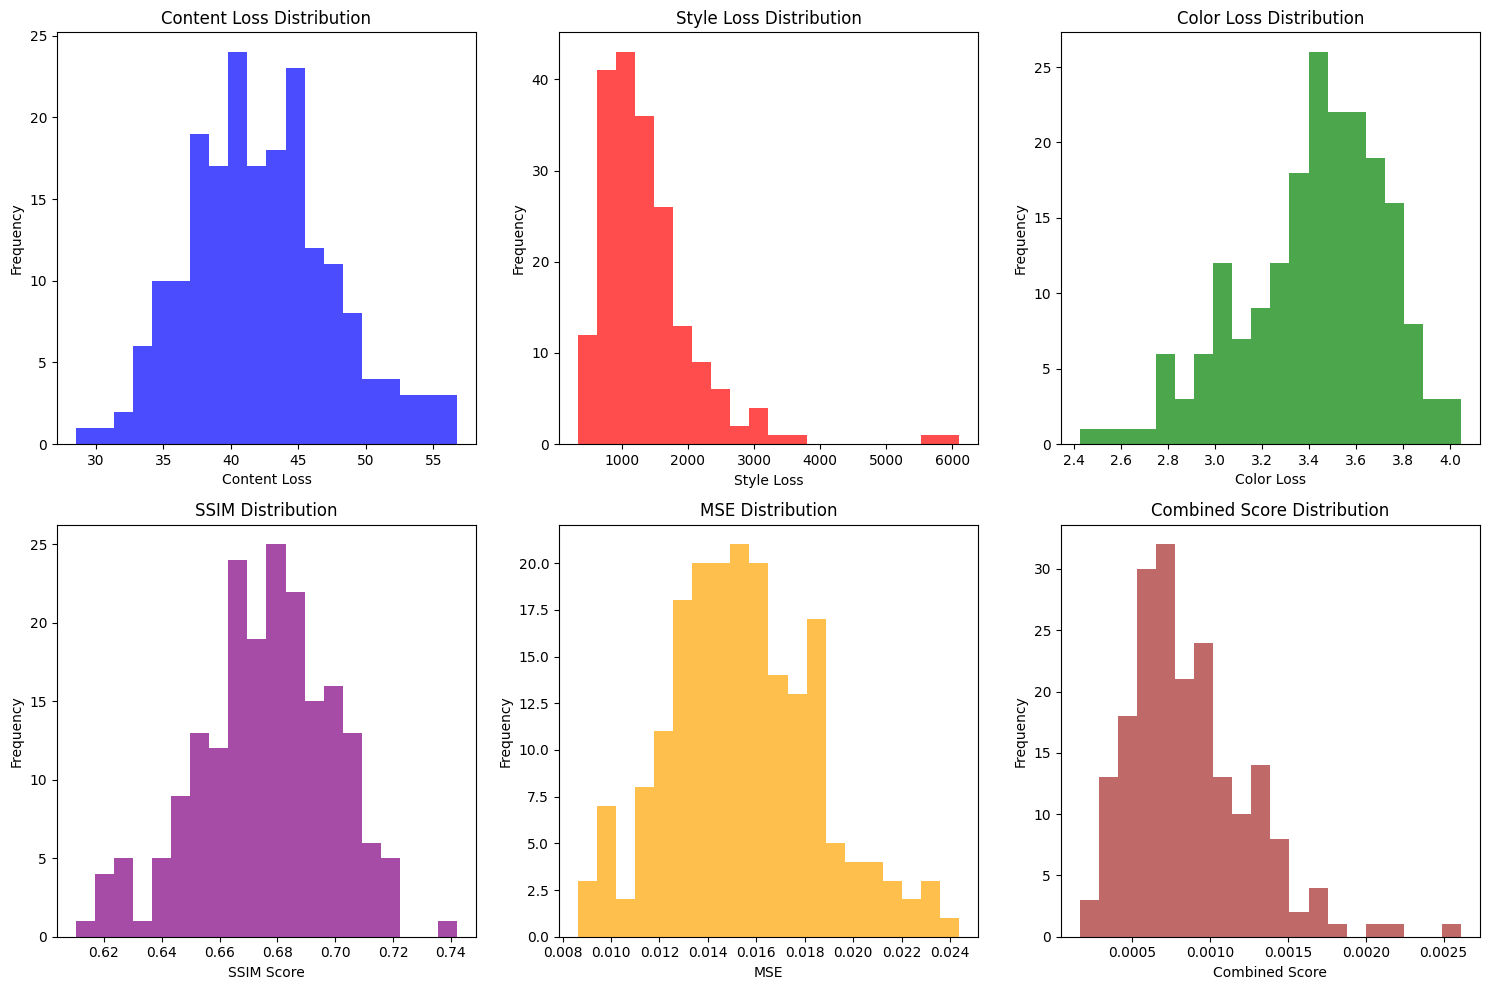


Best result: generated_L3_TMA_15_02_IB_HE_20250706-151750_HE_CD44_wasserstein.png (Score: 0.0026)
Worst result: generated_H12_TMA_15_02_IB_HE_20250706-151750_HE_CD44_wasserstein.png (Score: 0.0002)

EXAMPLE FILENAME MAPPINGS
Generated: generated_H7_TMA_15_02_IVB_HE_20250706-151750_HE_CD44_wasserstein.png
Original: H7_TMA_15_02_IVB_HE
Content path: /root/BiOSGen/data/HE/H7_TMA_15_02_IVB_HE.png
Style path: /root/BiOSGen/data/CD44/H7_TMA_15_02_IVB_CD44.png
---
Generated: generated_D10_TMA_15_02_IIB_HE_20250706-151750_HE_CD44_wasserstein.png
Original: D10_TMA_15_02_IIB_HE
Content path: /root/BiOSGen/data/HE/D10_TMA_15_02_IIB_HE.png
Style path: /root/BiOSGen/data/CD44/D10_TMA_15_02_IIB_CD44.png
---
Generated: generated_R12_TMA_15_02_IIIB_HE_20250706-151750_HE_CD44_wasserstein.png
Original: R12_TMA_15_02_IIIB_HE
Content path: /root/BiOSGen/data/HE/R12_TMA_15_02_IIIB_HE.png
Style path: /root/BiOSGen/data/CD44/R12_TMA_15_02_IIIB_CD44.png
---
Generated: generated_J11_TMA_15_02_IB_HE_20250706-1

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.models import VGG19_Weights
from PIL import Image
import numpy as np
import os
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import pandas as pd

# from losses import content_loss, style_loss, wasserstein_color_loss, moment_matching_loss

# VGG model loading (using your approach)
vgg = None

def get_vgg_model():
    """
    Lazy loading of VGG model to avoid unnecessary initialization
    """
    global vgg
    if vgg is None:
        weights = VGG19_Weights.IMAGENET1K_V1
        vgg = models.vgg19(weights=weights).features.eval()
        for param in vgg.parameters():
            param.requires_grad = False
    return vgg

def extract_features(image, layers):
    """
    Extracts features from specified layers of the VGG model.
    """
    model = get_vgg_model()
    device = image.device
    model = model.to(device)
    
    features = {}
    x = image
    
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[name] = x.clone()

    return features

def gram_matrix(features):
    """
    Compute Gram matrix of feature maps
    """
    B, C, H, W = features.shape
    features = features.view(B, C, H * W)
    gram_matrices = torch.bmm(features, features.transpose(1, 2))
    return gram_matrices / (C * H * W)

def content_loss_eval(original_image, generated_image, lambda_content=1.0):
    """
    Compute content loss between original and generated images using VGG-19.
    """
    if original_image.shape != generated_image.shape:
        generated_image = F.interpolate(generated_image, size=original_image.shape[2:], 
                                      mode="bilinear", align_corners=False)

    content_layers = ["21"]
    orig_features = extract_features(original_image, content_layers)
    gen_features = extract_features(generated_image, content_layers)
    
    orig_feat = orig_features["21"]
    gen_feat = gen_features["21"]
    
    B, C, H, W = orig_feat.shape
    loss = torch.sum((gen_feat - orig_feat) ** 2) / (C * H * W)
    
    return lambda_content * loss

def style_loss_eval(style_image, generated_image, style_layers=None, layer_weights=None, lambda_style=1.0):
    """
    Compute style loss between style reference image and generated image.
    """
    if style_image.shape != generated_image.shape:
        generated_image = F.interpolate(generated_image, 
                                       size=style_image.shape[2:], 
                                       mode="bilinear", 
                                       align_corners=False)
    
    if style_layers is None:
        style_layers = ["0", "5", "10", "19", "28", "32"]
    
    if layer_weights is None:
        layer_weights = [1.0] * len(style_layers)
    
    style_features = extract_features(style_image, style_layers)
    gen_features = extract_features(generated_image, style_layers)
    
    total_loss = 0
    for i, layer in enumerate(style_layers):
        weight = layer_weights[i]
        
        style_feat = style_features[layer]
        gen_feat = gen_features[layer]
        
        G_style = gram_matrix(style_feat)
        G_gen = gram_matrix(gen_feat)
        
        layer_loss = torch.sum((G_gen - G_style) ** 2)
        total_loss += weight * layer_loss
    
    return lambda_style * total_loss

def wasserstein_color_loss_eval(style_image, generated_image, lambda_color=1.0):
    """
    Approximate Wasserstein distance for color distribution matching.
    """
    if style_image.shape != generated_image.shape:
        generated_image = F.interpolate(generated_image, size=style_image.shape[2:], 
                                      mode="bilinear", align_corners=False)
    
    total_loss = 0
    
    for c in range(style_image.shape[1]):
        style_channel = style_image[:, c, :, :].flatten()
        gen_channel = generated_image[:, c, :, :].flatten()
        
        style_sorted, _ = torch.sort(style_channel)
        gen_sorted, _ = torch.sort(gen_channel)
        
        wasserstein_dist = torch.mean(torch.abs(style_sorted - gen_sorted))
        total_loss += wasserstein_dist
    
    return lambda_color * total_loss

def load_image(image_path, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """Load and preprocess image"""
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0).to(device)

def tensor_to_numpy(tensor):
    """Convert tensor to numpy array and denormalize"""
    device = tensor.device
    mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).to(device)
    
    tensor = tensor.squeeze(0)
    for i in range(3):
        tensor[i] = tensor[i] * std[i] + mean[i]
    
    tensor = torch.clamp(tensor, 0, 1)
    return tensor.permute(1, 2, 0).cpu().numpy()

def structural_similarity_eval(content_img, stylized_img):
    """Calculate SSIM between content and stylized images"""
    content_np = tensor_to_numpy(content_img)
    stylized_np = tensor_to_numpy(stylized_img)
    
    ssim_values = []
    for i in range(3):
        ssim_val = ssim(content_np[:, :, i], stylized_np[:, :, i], data_range=1.0)
        ssim_values.append(ssim_val)
    
    return np.mean(ssim_values)

def extract_original_filename(generated_filename):
    """Extract original filename from generated filename"""
    if generated_filename.startswith('generated_'):
        without_prefix = generated_filename[10:]
        
        parts = without_prefix.split('_')
        
        # Find index where date pattern starts (8 digits followed by dash)
        date_index = -1
        for i, part in enumerate(parts):
            if len(part) >= 8 and part[:8].isdigit() and '-' in part:
                date_index = i
                break
        
        if date_index > 0:
            original_parts = parts[:date_index]
            original_name = '_'.join(original_parts)
            return original_name
    
    return None

def extract_style_prefix(original_name):
    """
    Extract the style prefix from the original filename.
    For 'A2_TMA_15_02_IVB_HE', this would return 'A2_TMA_15_02_IVB_'
    """
    if original_name.endswith('_HE'):
        # Remove the '_HE' suffix and add underscore for prefix
        base_name = original_name[:-3]  # Remove '_HE'
        return base_name + '_'
    else:
        # Fallback: assume last part after underscore is the modality
        parts = original_name.split('_')
        if len(parts) > 1:
            # Join all parts except the last one, then add underscore
            return '_'.join(parts[:-1]) + '_'
    
    return original_name + '_'

def find_matching_files(content_dir, style_dir, original_name):
    """Find matching content and style files"""
    extensions = ['.png', '.jpg', '.jpeg', '.tiff', '.bmp']
    
    content_path = None
    style_path = None
    
    # Look for content file (exact match)
    for ext in extensions:
        potential_path = os.path.join(content_dir, f"{original_name}{ext}")
        if os.path.exists(potential_path):
            content_path = potential_path
            break
    
    # Look for style file (using prefix matching)
    if style_dir:
        style_prefix = extract_style_prefix(original_name)
        
        # First try exact prefix match
        for ext in extensions:
            potential_path = os.path.join(style_dir, f"{style_prefix}{ext}")
            if os.path.exists(potential_path):
                style_path = potential_path
                break
        
        # If no exact prefix match, try finding files that start with the prefix
        if style_path is None:
            for filename in os.listdir(style_dir):
                if filename.startswith(style_prefix):
                    name_without_ext = os.path.splitext(filename)[0]
                    ext = os.path.splitext(filename)[1].lower()
                    if ext in extensions:
                        style_path = os.path.join(style_dir, filename)
                        break
    
    return content_path, style_path

def evaluate_single_result(content_path, style_path, stylized_path, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """Evaluate a single style transfer result"""
    content_img = load_image(content_path, device)
    stylized_img = load_image(stylized_path, device)
    
    with torch.no_grad():
        # Content preservation metrics
        content_loss_val = content_loss_eval(content_img, stylized_img).item()
        ssim_score = structural_similarity_eval(content_img, stylized_img)
        
        # MSE for pixel-level comparison
        mse = F.mse_loss(content_img, stylized_img).item()
        
        # Style transfer metrics (if style image available)
        style_loss_val = None
        color_loss_val = None
        
        if style_path and os.path.exists(style_path):
            style_img = load_image(style_path, device)
            style_loss_val = style_loss_eval(style_img, stylized_img).item()
            color_loss_val = wasserstein_color_loss_eval(style_img, stylized_img).item()
        
        # Combined score (you can adjust weights)
        if style_loss_val is not None:
            combined_score = 1 / (1 + content_loss_val + style_loss_val + (color_loss_val or 0))
        else:
            combined_score = 1 / (1 + content_loss_val + mse)
        
    return {
        'content_loss': content_loss_val,
        'style_loss': style_loss_val,
        'color_loss': color_loss_val,
        'ssim': ssim_score,
        'mse': mse,
        'combined_score': combined_score
    }

def evaluate_directory(results_dir, content_dir, style_dir=None, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """Evaluate all results in a directory"""
    results = []
    
    for result_file in os.listdir(results_dir):
        if not result_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
            
        result_path = os.path.join(results_dir, result_file)
        
        # Extract original filename
        original_name = extract_original_filename(result_file)
        
        if original_name is None:
            print(f"Could not extract original name from: {result_file}")
            continue
        
        # Find matching content and style files
        content_path, style_path = find_matching_files(content_dir, style_dir, original_name)
        
        if content_path is None:
            print(f"Could not find content file for: {original_name}")
            continue
        
        # Evaluate this result
        try:
            metrics = evaluate_single_result(content_path, style_path, result_path, device)
            metrics['filename'] = result_file
            metrics['original_name'] = original_name
            metrics['content_path'] = content_path
            metrics['style_path'] = style_path
            metrics['style_used'] = style_path is not None
            
            results.append(metrics)
            print(f"Evaluated: {result_file} -> {original_name}")
            if style_path:
                print(f"  Style: {os.path.basename(style_path)}")
            else:
                print(f"  Style: Not found")
            
        except Exception as e:
            print(f"Error evaluating {result_file}: {str(e)}")
            continue
    
    return pd.DataFrame(results)

def plot_results(results_df, save_path='evaluation_results.png'):
    """Plot evaluation results"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Content Loss
    axes[0, 0].hist(results_df['content_loss'], bins=20, alpha=0.7, color='blue')
    axes[0, 0].set_title('Content Loss Distribution')
    axes[0, 0].set_xlabel('Content Loss')
    axes[0, 0].set_ylabel('Frequency')
    
    # Style Loss (if available)
    if results_df['style_loss'].notna().any():
        style_data = results_df['style_loss'].dropna()
        axes[0, 1].hist(style_data, bins=20, alpha=0.7, color='red')
        axes[0, 1].set_title('Style Loss Distribution')
        axes[0, 1].set_xlabel('Style Loss')
        axes[0, 1].set_ylabel('Frequency')
    else:
        axes[0, 1].text(0.5, 0.5, 'No Style Loss\n(Content-only evaluation)', 
                       ha='center', va='center', transform=axes[0, 1].transAxes)
        axes[0, 1].set_title('Style Loss Distribution')
    
    # Color Loss (if available)
    if results_df['color_loss'].notna().any():
        color_data = results_df['color_loss'].dropna()
        axes[0, 2].hist(color_data, bins=20, alpha=0.7, color='green')
        axes[0, 2].set_title('Color Loss Distribution')
        axes[0, 2].set_xlabel('Color Loss')
        axes[0, 2].set_ylabel('Frequency')
    else:
        axes[0, 2].text(0.5, 0.5, 'No Color Loss\n(Content-only evaluation)', 
                       ha='center', va='center', transform=axes[0, 2].transAxes)
        axes[0, 2].set_title('Color Loss Distribution')
    
    # SSIM
    axes[1, 0].hist(results_df['ssim'], bins=20, alpha=0.7, color='purple')
    axes[1, 0].set_title('SSIM Distribution')
    axes[1, 0].set_xlabel('SSIM Score')
    axes[1, 0].set_ylabel('Frequency')
    
    # MSE
    axes[1, 1].hist(results_df['mse'], bins=20, alpha=0.7, color='orange')
    axes[1, 1].set_title('MSE Distribution')
    axes[1, 1].set_xlabel('MSE')
    axes[1, 1].set_ylabel('Frequency')
    
    # Combined Score
    axes[1, 2].hist(results_df['combined_score'], bins=20, alpha=0.7, color='brown')
    axes[1, 2].set_title('Combined Score Distribution')
    axes[1, 2].set_xlabel('Combined Score')
    axes[1, 2].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def main():
    """Main evaluation function"""
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")
    
    # Define your directories
    results_dir = "results/20250706-151750_HE_CD44_wasserstein"  # Your generated images
    content_dir = "/root/BiOSGen/data/HE"  # Original content images
    style_dir = "/root/BiOSGen/data/CD44"     # Style reference images (optional)
    
    # Evaluate all results
    print("Starting evaluation...")
    results_df = evaluate_directory(results_dir, content_dir, style_dir, device)
    
    if len(results_df) == 0:
        print("No results found or evaluated. Please check your directories and file naming.")
        return
    
    # Save results
    results_df.to_csv('evaluation_metrics.csv', index=False)
    print(f"Results saved to evaluation_metrics.csv")
    
    # Print summary statistics
    print("\n" + "="*50)
    print("EVALUATION SUMMARY")
    print("="*50)
    print(f"Total images evaluated: {len(results_df)}")
    print(f"Images with style reference found: {results_df['style_used'].sum()}")
    print(f"Average Content Loss: {results_df['content_loss'].mean():.4f}")
    print(f"Average MSE: {results_df['mse'].mean():.4f}")
    print(f"Average SSIM: {results_df['ssim'].mean():.4f}")
    
    # Handle cases where style_loss might be None
    if results_df['style_loss'].notna().any():
        print(f"Average Style Loss: {results_df['style_loss'].mean():.4f}")
    else:
        print("No style loss calculated (content-only evaluation)")
    
    if results_df['color_loss'].notna().any():
        print(f"Average Color Loss: {results_df['color_loss'].mean():.4f}")
    else:
        print("No color loss calculated (content-only evaluation)")
    
    print(f"Average Combined Score: {results_df['combined_score'].mean():.4f}")
    
    # Plot results
    plot_results(results_df)
    
    # Find best and worst results
    best_combined = results_df.loc[results_df['combined_score'].idxmax()]
    worst_combined = results_df.loc[results_df['combined_score'].idxmin()]
    
    print(f"\nBest result: {best_combined['filename']} (Score: {best_combined['combined_score']:.4f})")
    print(f"Worst result: {worst_combined['filename']} (Score: {worst_combined['combined_score']:.4f})")
    
    # Show some example mappings
    print("\n" + "="*50)
    print("EXAMPLE FILENAME MAPPINGS")
    print("="*50)
    for idx, row in results_df.head(5).iterrows():
        print(f"Generated: {row['filename']}")
        print(f"Original: {row['original_name']}")
        print(f"Content path: {row['content_path']}")
        print(f"Style path: {row['style_path']}")
        print("---")

def test_filename_extraction():
    """Test the filename extraction and style prefix functions"""
    test_files = [
        "generated_A2_TMA_15_02_IVB_HE_20250706-184908_HE_AR_wasserstein.png",
        "generated_B1_TMA_10_01_IVB_HE_20250707-123456_HE_AR_cycle.png",
        "generated_C3_TMA_05_03_IVB_HE_20250708-094512_HE_AR_pix2pix.png"
    ]
    
    print("Testing filename extraction and style prefix generation:")
    for filename in test_files:
        original = extract_original_filename(filename)
        if original:
            style_prefix = extract_style_prefix(original)
            print(f"Generated: {filename}")
            print(f"Original: {original}")
            print(f"Style prefix: {style_prefix}")
            print(f"Expected style file: {style_prefix}[extension]")
        else:
            print(f"Failed to extract from: {filename}")
        print("---")

if __name__ == "__main__":
    # Uncomment to test filename extraction
    # test_filename_extraction()
    
    # Run main evaluation
    main()